# 第8週：分析PTT八卦版水庫相關文章之詞彙關係

**Author:** 蘇舫萱  
**Date created:** 2021/09/  
**Last modified:** 2020/09/  
本週課程為「文辭和文件分析」，目的為透過TF-IDF, N-gram等方法找出文章以及字詞間的關聯。在這個Jupyter Notebook中將會以八卦版水庫缺水相關文章做為分析資料。


## 大綱

- 1. 套件說明
- 2. 資料前處理
    - 2.1 基本資料介紹
    - 2.2 資料清理
    - 2.3 文章斷詞與整理
- 3. TF-IDF
    - 3.1 計算每篇文章的詞數
    - 3.2 合併需要的資料欄位
    - 3.3 計算tf-idf值
    - 3.4 檢視結果
- 4. 透過結巴斷詞與N-gram幫助建立字典
    - 4.1 Bigram
    - 4.2 Trigram
- 5. 使用自建字典
- 6. 建立Ngram預測模型
- 7. Bigram視覺化
- 8. Pairwise correlation
    - 8.1 找出相關性高的詞彙
    - 8.2 畫出關係圖
- 9. 計算文章相似度


## 1. 套件說明
下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- numpy: 為科學運算所提供的套件。提供許多數學公式的實作以及高效率的陣列、矩陣運算。
- NLTK: 全名為Natural Language Tool Kit，自然語言處理工具。
- jieba: 中文斷詞套件。
- re: 正規表達式套件。

- math: 數學運算工具。
- collections: 提供額外的數據類型。
- wordcloud: 文字雲繪圖工具。
- matplotlib: 繪圖工具。
- networkx: 網絡圖建構、繪製工具。
- CountVectorizer,TfidfTransformer: sklearn中計算詞頻與tf-idf的套件。
- numpy.linalg: 矩陣與向量運算套件。

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
import re
import jieba
import jieba.analyse
from datetime import datetime
from wordcloud import WordCloud 
import math
from nltk import ngrams
from collections import defaultdict
from nltk import FreqDist
from collections import Counter, namedtuple
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from numpy.linalg import norm

In [10]:
plt.rcParams['font.sans-serif']=['SimHei'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus']=False #使負號能夠顯示

In [11]:
# cloab 字體設定
# !wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

# 新增字體
# matplotlib.font_manager.fontManager.addfont('taipei_sans_tc_beta.ttf')

# 將 font-family 設為 Taipei Sans TC Beta
# 設定完後，之後的圖表都可以顯示中文了
# matplotlib.rc('font', family='Taipei Sans TC Beta')

## 2. 資料前處理

### 2.1 基本資料介紹
- 資料來源: 文字平台收集PTT Gossip版2020/01/01 ~ 2021/04/07  所有文章
- 資料集： ptt_gos_water_articleMetaData.csv
- 關鍵字：水庫、水情、缺水
- 資料時間：2020/01/01 ~ 2021/04/07 
- 資料筆數：共 644 篇文章

In [12]:
#匯入資料
MetaData = pd.read_csv('./raw_data/ptt_gos_water_articleMetaData.csv', encoding='UTF-8')

In [13]:
MetaData.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
0,[問卦]台灣水情吃緊跟鳳梨外銷中國誰比較重要！,2021/3/1,13:45:31,https://www.ptt.cc/bbs/Gossiping/M.1614606334....,wan5389,Gossiping,27,15,2,魯蛇家鄉最近停水好幾天引起民怨！\n就查了最近的水情資料！\nhttps://i.imgur...
1,[新聞]水情告急！新竹以南7水庫蓄水率陷10%保,2021/3/2,03:12:58,https://www.ptt.cc/bbs/Gossiping/M.1614654780....,A80211ab,Gossiping,72,33,2,新頭殼\n\n\n顏得智\n\n\n水情告急！新竹以南7水庫蓄水率陷10%保衛戰 春季雨量展...
2,[新聞]水情再趨嚴峻高雄今天凌晨0時起暫停支,2021/3/4,02:53:32,https://www.ptt.cc/bbs/Gossiping/M.1614826416....,shangguan125,Gossiping,102,56,6,備註請放最後面 違者新聞文章刪除\n\n1.媒體來源:\n聯合新聞網\n2.記者署名:\n記...


### 2.2 資料清理  
- 去除特殊字元與標點符號

In [14]:
#移除PTT貼新聞時會出現的格式用字
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('(媒體來源|記者署名|完整新聞標題|完整新聞內文|完整新聞連結|(或短網址)|備註:|備註請放最後面|違者新聞文章刪除)', '', x))
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('(http|https)://.*', '', x))
#只留下中文字
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('[^\u4e00-\u9fa5]+', '',x))

In [15]:
MetaData.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
0,[問卦]台灣水情吃緊跟鳳梨外銷中國誰比較重要！,2021/3/1,13:45:31,https://www.ptt.cc/bbs/Gossiping/M.1614606334....,wan5389,Gossiping,27,15,2,魯蛇家鄉最近停水好幾天引起民怨就查了最近的水情資料發現最近新竹以南水情不是很樂觀卻沒有中央官...
1,[新聞]水情告急！新竹以南7水庫蓄水率陷10%保,2021/3/2,03:12:58,https://www.ptt.cc/bbs/Gossiping/M.1614654780....,A80211ab,Gossiping,72,33,2,新頭殼顏得智水情告急新竹以南水庫蓄水率陷保衛戰春季雨量展望暫不樂觀水情告急嘉義台南地區於月日...
2,[新聞]水情再趨嚴峻高雄今天凌晨0時起暫停支,2021/3/4,02:53:32,https://www.ptt.cc/bbs/Gossiping/M.1614826416....,shangguan125,Gossiping,102,56,6,聯合新聞網記者王昭月高雄即時報導水情再趨嚴峻高雄今天凌晨時起暫停支援台南用水南部地區水情再趨...


### 2.3 文章斷詞與整理

In [16]:
#設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')

#新增stop words
#jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [17]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選不在停用字的字與字元數大於1的字詞
    return seg_list

In [18]:
data = MetaData.copy()
data['word'] = data.sentence.apply(getToken)

Building prefix dict from D:\acer\Desktop\school\助教\week8\dict\dict.txt.big ...
Loading model from cache C:\Users\acer\AppData\Local\Temp\jieba.ua066fb3922cf75312978dad23f36642f.cache
Loading model cost 3.418 seconds.
Prefix dict has been built successfully.


In [19]:
# 將word欄位展開
data = data.explode('word')

In [20]:
data.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,word
0,[問卦]台灣水情吃緊跟鳳梨外銷中國誰比較重要！,2021/3/1,13:45:31,https://www.ptt.cc/bbs/Gossiping/M.1614606334....,wan5389,Gossiping,27,15,2,魯蛇家鄉最近停水好幾天引起民怨就查了最近的水情資料發現最近新竹以南水情不是很樂觀卻沒有中央官...,魯蛇
0,[問卦]台灣水情吃緊跟鳳梨外銷中國誰比較重要！,2021/3/1,13:45:31,https://www.ptt.cc/bbs/Gossiping/M.1614606334....,wan5389,Gossiping,27,15,2,魯蛇家鄉最近停水好幾天引起民怨就查了最近的水情資料發現最近新竹以南水情不是很樂觀卻沒有中央官...,家鄉
0,[問卦]台灣水情吃緊跟鳳梨外銷中國誰比較重要！,2021/3/1,13:45:31,https://www.ptt.cc/bbs/Gossiping/M.1614606334....,wan5389,Gossiping,27,15,2,魯蛇家鄉最近停水好幾天引起民怨就查了最近的水情資料發現最近新竹以南水情不是很樂觀卻沒有中央官...,停水


In [21]:
#計算各詞彙在各文章中出現的次數
word_count = data.groupby(['artUrl','word'],as_index=False).size()
word_count.rename(columns={'size': 'count'}, inplace=True)

In [22]:
word_count

,artUrl,word,count
0,https://www.ptt.cc/bbs/Gossiping/M.1580821689....,一圈,1
1,https://www.ptt.cc/bbs/Gossiping/M.1580821689....,公尺,1
2,https://www.ptt.cc/bbs/Gossiping/M.1580821689....,同學,1
3,https://www.ptt.cc/bbs/Gossiping/M.1580821689....,快姆,1
4,https://www.ptt.cc/bbs/Gossiping/M.1580821689....,水庫,1
...,...,...,...
31418,https://www.ptt.cc/bbs/Gossiping/M.1617806322....,顯示,1
31419,https://www.ptt.cc/bbs/Gossiping/M.1617806322....,高雄,1
31420,https://www.ptt.cc/bbs/Gossiping/M.1617806322....,鬼扯,1
31421,https://www.ptt.cc/bbs/Gossiping/M.1617806322....,點名,1


## 3. TF-IDF
TF-IDF 是一種統計方法，可用來評估單詞對於文件的集合的重要程度  
### 3.1 計算每篇文章的詞數

In [23]:
total_words = data.groupby(['artUrl'],as_index=False).size()
total_words.rename(columns={'size': 'total'}, inplace=True)
total_words

,artUrl,total
0,https://www.ptt.cc/bbs/Gossiping/M.1580821689....,7
1,https://www.ptt.cc/bbs/Gossiping/M.1581680600....,241
2,https://www.ptt.cc/bbs/Gossiping/M.1581728574....,325
3,https://www.ptt.cc/bbs/Gossiping/M.1581733062....,10
4,https://www.ptt.cc/bbs/Gossiping/M.1582373866....,156
...,...,...
639,https://www.ptt.cc/bbs/Gossiping/M.1617713484....,46
640,https://www.ptt.cc/bbs/Gossiping/M.1617767509....,11
641,https://www.ptt.cc/bbs/Gossiping/M.1617771589....,18
642,https://www.ptt.cc/bbs/Gossiping/M.1617773771....,18


### 3.2 合併需要的資料欄位
- 合併 **每個詞彙在每個文章中出現的次數** 與 **每篇文章的詞數**
- 新增各個詞彙在所有詞彙中的總數欄位

In [24]:
water_words = word_count.merge(total_words,on = 'artUrl',how = 'left')
water_words

,artUrl,word,count,total
0,https://www.ptt.cc/bbs/Gossiping/M.1580821689....,一圈,1,7
1,https://www.ptt.cc/bbs/Gossiping/M.1580821689....,公尺,1,7
2,https://www.ptt.cc/bbs/Gossiping/M.1580821689....,同學,1,7
3,https://www.ptt.cc/bbs/Gossiping/M.1580821689....,快姆,1,7
4,https://www.ptt.cc/bbs/Gossiping/M.1580821689....,水庫,1,7
...,...,...,...,...
31418,https://www.ptt.cc/bbs/Gossiping/M.1617806322....,顯示,1,197
31419,https://www.ptt.cc/bbs/Gossiping/M.1617806322....,高雄,1,197
31420,https://www.ptt.cc/bbs/Gossiping/M.1617806322....,鬼扯,1,197
31421,https://www.ptt.cc/bbs/Gossiping/M.1617806322....,點名,1,197


### 3.3 計算 tf-idf 值
- 以每篇文章爲單位，計算每個詞彙的 tf-idf 值  
    - TF (Term Frequency):某一個詞彙在某一個文件中所出現的頻率。  
        詞彙在該文件中出現次數 / 該文件中詞彙總數  
    - IDF (Inverse Document Frequent):為文件數除以某特定詞彙有被多少文件所提及的數量取log。評估詞彙在文集的獨特性  
        log( 總文件數量 / 包含該詞彙的文件數量 ) 

In [25]:
#計算tf
water_words_tf_idf = water_words.assign(tf = water_words.iloc[:,2]/water_words.iloc[:,3])

In [26]:
# 計算每個詞彙出現在幾篇文章中
idf_df = water_words.groupby(['word'],as_index=False).size()
water_words_tf_idf = water_words_tf_idf.merge(idf_df,on = 'word',how = 'left')

In [27]:
#計算idf
water_words_tf_idf = water_words_tf_idf.assign(idf = water_words_tf_idf.iloc[:,5]
                                               .apply(lambda x: math.log((len(total_words)/x),10)))

water_words_tf_idf = water_words_tf_idf.drop(labels=['size'],axis=1)

In [28]:
#計算tf*idf
water_words_tf_idf = water_words_tf_idf.assign(tf_idf = water_words_tf_idf.iloc[:,4]*water_words_tf_idf.iloc[:,5])

In [29]:
water_words_tf_idf.head()

,artUrl,word,count,total,tf,idf,tf_idf
0,https://www.ptt.cc/bbs/Gossiping/M.1580821689....,一圈,1,7,0.142857,2.331765,0.333109
1,https://www.ptt.cc/bbs/Gossiping/M.1580821689....,公尺,1,7,0.142857,1.303736,0.186248
2,https://www.ptt.cc/bbs/Gossiping/M.1580821689....,同學,1,7,0.142857,2.331765,0.333109
3,https://www.ptt.cc/bbs/Gossiping/M.1580821689....,快姆,1,7,0.142857,2.808886,0.401269
4,https://www.ptt.cc/bbs/Gossiping/M.1580821689....,水庫,1,7,0.142857,0.246593,0.035228


### 3.4 檢視結果

In [30]:
# 選出每篇文章，tf-idf值最大的五個詞
group = water_words_tf_idf.groupby("artUrl").apply(lambda x : x.nlargest(5, "tf_idf"))

In [31]:
group.loc[:,["word","tf_idf"]][0:15]

word    tf_idf
artUrl                                                                
https://www.ptt.cc/bbs/Gossiping/M.1580821689.A... 3      快姆  0.401269
                                                   5     走不動  0.401269
                                                   0      一圈  0.333109
                                                   2      同學  0.333109
                                                   6      關係  0.242135
https://www.ptt.cc/bbs/Gossiping/M.1581680600.A... 83     日暈  0.069931
                                                   170    遺址  0.058276
                                                   117    湖山  0.048377
                                                   179    雲林  0.043774
                                                   59    展示館  0.034965
https://www.ptt.cc/bbs/Gossiping/M.1581728574.A... 223  嘉南大圳  0.084881
                                                   222    嘉南  0.062582
                                                   322   烏山頭  0.044593
                                                   364  農田水利  0.038961
                                                   377    開工  0.038582

#### 計算整個文集中較常 tf-idf 值高的字

In [32]:
# 從每篇文章挑選出tf-idf最大的十個詞
(water_words_tf_idf.groupby("artUrl").apply(lambda x : x.nlargest(10, "tf_idf")).reset_index(drop=True)
# 計算每個詞被選中的次數
.groupby(['word'],as_index=False).size()
).sort_values('size', ascending=False).head(10) #排序看前十名

,word,size
2685,水庫,34
3527,缺水,28
3317,石門水庫,22
2391,曾文水庫,21
2657,水位,20
3552,翡翠水庫,18
619,八卦,17
1008,台灣,16
2925,清淤,16
166,下雨,14


## 4. 透過結巴斷詞與N-gram幫助建立字典
N-gram 指文本中連續出現的n個語詞。 透過N-gram我們可以找出有哪些詞彙較常一起出現，檢查是否需要加入自定義字典中。  
N-gram範例：

In [33]:
token = jieba.lcut("中山資管全國第一")
token

['中山', '資管', '全國', '第一']

In [34]:
bigram  = ngrams(token, 2)

In [35]:
list(bigram)

[('中山', '資管'), ('資管', '全國'), ('全國', '第一')]

In [36]:
trigram  = ngrams(token, 3)

In [37]:
list(trigram)

[('中山', '資管', '全國'), ('資管', '全國', '第一')]

### 4.1 Bigram

In [38]:
# 設定 bigram 斷詞 function
def bigram_getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [39]:
water_bigram = MetaData.copy()
water_bigram["word"] = water_bigram.sentence.apply(bigram_getToken)

In [40]:
water_bigram = water_bigram.explode('word')
water_bigram.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,word
0,[問卦]台灣水情吃緊跟鳳梨外銷中國誰比較重要！,2021/3/1,13:45:31,https://www.ptt.cc/bbs/Gossiping/M.1614606334....,wan5389,Gossiping,27,15,2,魯蛇家鄉最近停水好幾天引起民怨就查了最近的水情資料發現最近新竹以南水情不是很樂觀卻沒有中央官...,魯蛇 家鄉
0,[問卦]台灣水情吃緊跟鳳梨外銷中國誰比較重要！,2021/3/1,13:45:31,https://www.ptt.cc/bbs/Gossiping/M.1614606334....,wan5389,Gossiping,27,15,2,魯蛇家鄉最近停水好幾天引起民怨就查了最近的水情資料發現最近新竹以南水情不是很樂觀卻沒有中央官...,家鄉 停水
0,[問卦]台灣水情吃緊跟鳳梨外銷中國誰比較重要！,2021/3/1,13:45:31,https://www.ptt.cc/bbs/Gossiping/M.1614606334....,wan5389,Gossiping,27,15,2,魯蛇家鄉最近停水好幾天引起民怨就查了最近的水情資料發現最近新竹以南水情不是很樂觀卻沒有中央官...,停水 幾天


#### 統計最常出現的bigram組合

In [41]:
# 計算每個組合出現的次數
water_bigram_count = water_bigram.groupby(["word"],as_index=False).size()

In [42]:
# 清除包含英文或數字的bigram組合
wb_filter = list(water_bigram_count["word"].apply(lambda x: True if not re.search("[0-9a-zA-Z]",x) else False))
water_bigram_count[wb_filter].sort_values(by=['size'], ascending=False).head(10)

,word,size
5772,南化 水庫,58
7081,台灣 缺水,56
21934,減壓 供水,54
27206,美濃 水庫,52
19672,水庫 蓄水量,51
21500,海水 淡化,49
22667,烏山頭 水庫,48
18448,民生 用水,45
16940,有沒有 八卦,42
19868,水情 吃緊,39


### 4.2 Trigram

In [43]:
# 設定 trigram 斷詞 function
def trigram_getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = ngrams(seg_list, 3)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [44]:
water_trigram = MetaData.copy()
water_trigram["word"] = water_trigram.sentence.apply(trigram_getToken)
water_trigram = water_trigram.explode('word')
water_trigram.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,word
0,[問卦]台灣水情吃緊跟鳳梨外銷中國誰比較重要！,2021/3/1,13:45:31,https://www.ptt.cc/bbs/Gossiping/M.1614606334....,wan5389,Gossiping,27,15,2,魯蛇家鄉最近停水好幾天引起民怨就查了最近的水情資料發現最近新竹以南水情不是很樂觀卻沒有中央官...,魯蛇 家鄉 停水
0,[問卦]台灣水情吃緊跟鳳梨外銷中國誰比較重要！,2021/3/1,13:45:31,https://www.ptt.cc/bbs/Gossiping/M.1614606334....,wan5389,Gossiping,27,15,2,魯蛇家鄉最近停水好幾天引起民怨就查了最近的水情資料發現最近新竹以南水情不是很樂觀卻沒有中央官...,家鄉 停水 幾天
0,[問卦]台灣水情吃緊跟鳳梨外銷中國誰比較重要！,2021/3/1,13:45:31,https://www.ptt.cc/bbs/Gossiping/M.1614606334....,wan5389,Gossiping,27,15,2,魯蛇家鄉最近停水好幾天引起民怨就查了最近的水情資料發現最近新竹以南水情不是很樂觀卻沒有中央官...,停水 幾天 民怨


#### 統計最常出現的trigram組合

In [45]:
# 計算每個組合出現的次數
water_trigram_count = water_trigram.groupby(["word"],as_index=False).size()
# 清除包含英文或數字的trigram組合
wb_filter = list(water_trigram_count["word"].apply(lambda x: True if not re.search("[0-9a-zA-Z]",x) else False))
water_trigram_count[wb_filter].sort_values(by=['size'], ascending=False).head(10)

,word,size
10441,夜間 減壓 供水,21
20996,水利 南區 水資源,14
20434,民生 產業 用水,12
23005,水資源 回收 中心,12
8399,吳淑玲 台南 即時,9
11769,實施 夜間 減壓,8
19223,板本 萬能 問板,8
8649,問板 兩則 看板,8
18997,未滿 繁體中文 水桶,8
4467,兩則 看板 禁止,8


從上面的 bigram 和 trigram 的結果中，我們發現"美濃 水庫","烏山頭 水庫","減壓 供水"等詞可以組合在一起，所以我們增加自定義字典來幫助斷詞能更準確。  
我們將詞彙整理好存在 dict 文件夾中的 water_lexicon.txt 中。

## 5. 使用自建字典

In [46]:
#新增水情相關自定義字典
jieba.load_userdict('./dict/water_lexicon.txt')

**使用自建辭典進行斷詞與計算**

In [47]:
#剛才的斷詞結果沒有使用新增的辭典，因此我們重新進行斷詞
data2 = MetaData.copy()
data2['word'] = data2.sentence.apply(getToken)
data2 = data2.explode('word')

In [48]:
#再次計算各詞彙在各文章中出現的次數
word_count2 = data2.groupby(['artUrl','word'],as_index=False).size()
word_count2.rename(columns={'size': 'count'}, inplace=True)

In [49]:
wb_filter = list(word_count2["word"].apply(lambda x: True if not re.search("[0-9a-zA-Z]",x) else False))
word_count2 = word_count2[wb_filter].sort_values(by=['count'], ascending=False)
word_count2.head(10)

,artUrl,word,count
15564,https://www.ptt.cc/bbs/Gossiping/M.1606828461....,水庫,35
9565,https://www.ptt.cc/bbs/Gossiping/M.1599972470....,露營,25
10036,https://www.ptt.cc/bbs/Gossiping/M.1600761869....,水庫,20
10075,https://www.ptt.cc/bbs/Gossiping/M.1600761869....,緊急,18
8477,https://www.ptt.cc/bbs/Gossiping/M.1597337369....,澎湖,18
417,https://www.ptt.cc/bbs/Gossiping/M.1582373866....,大頭,18
15358,https://www.ptt.cc/bbs/Gossiping/M.1606628537....,水庫,17
5571,https://www.ptt.cc/bbs/Gossiping/M.1594124299....,水庫,17
25725,https://www.ptt.cc/bbs/Gossiping/M.1616559373....,水庫,17
2109,https://www.ptt.cc/bbs/Gossiping/M.1588937424....,石門水庫,17


## 6. 建立Ngram預測模型
引入Markov假設，也就是當前的這個字僅僅與前幾個有限的字相關   
$$P(w_i|w_1,...,w_{i-1})=P(w_i|w_{i-m+1},...,w_{i-1})$$  
bi-gram (m=2):
$$ P(w_i|w_{i-1})=\frac {count(w_{i-1},w_i)} {count(w_{i-1})} $$   
tri-gram (m=3):  
$$ P(w_i|w_{i-2},w_{i-1})=\frac {count(w_{i-2},w_{i-1},w_i)} {count(w_{i-2},w_{i-1})} $$   



參考網站：
- [N-gram Language Models](https://towardsdatascience.com/n-gram-language-models-af6085435eeb)
- [自然語言處理 — 使用 N-gram 實現輸入文字預測](https://medium.com/%E6%89%8B%E5%AF%AB%E7%AD%86%E8%A8%98/%E8%87%AA%E7%84%B6%E8%AA%9E%E8%A8%80%E8%99%95%E7%90%86-%E4%BD%BF%E7%94%A8-n-gram-%E5%AF%A6%E7%8F%BE%E8%BC%B8%E5%85%A5%E6%96%87%E5%AD%97%E9%A0%90%E6%B8%AC-10ac622aab7a)
- [自然語言處理中N-Gram模型介紹](https://zhuanlan.zhihu.com/p/32829048)

---
**以Bi-gram為例： 中山 __ 該填甚麼?**  
[ ["中山","資管","全國","第一"], ["歡迎","來到","中山","大學"], ["中山","資管","碩士","開放","報名"] ]  
$$ p(w|中山) = \frac {count(中山,w)} {count(中山)} $$
           
$$ p(資管|中山) = \frac {2} {3} $$
$$ p(大學|中山) = \frac {1} {3} $$

In [50]:
test_list = [["中山","資管","全國","第一"],
           ["歡迎","來到","中山","大學"],
           ["中山","資管","碩士","開放","報名"]]

In [51]:
N=2
ngram_prediction = dict()
total_grams = list()
words = list()
Word = namedtuple('Word', ['word', 'prob'])

for doc in test_list:
    #加上開頭和結尾 tag
    split_words = ['<s>'] + list(doc) + ['</s>']
    # 計算分子
    [total_grams.append(tuple(split_words[i:i+N])) for i in range(len(split_words)-N+1)]
    # 計算分母
    [words.append(tuple(split_words[i:i+N-1])) for i in range(len(split_words)-N+2)]
        
total_word_counter = Counter(total_grams)
word_counter = Counter(words)

In [52]:
# 分子
total_word_counter

Counter({('<s>', '中山'): 2,
         ('中山', '資管'): 2,
         ('資管', '全國'): 1,
         ('全國', '第一'): 1,
         ('第一', '</s>'): 1,
         ('<s>', '歡迎'): 1,
         ('歡迎', '來到'): 1,
         ('來到', '中山'): 1,
         ('中山', '大學'): 1,
         ('大學', '</s>'): 1,
         ('資管', '碩士'): 1,
         ('碩士', '開放'): 1,
         ('開放', '報名'): 1,
         ('報名', '</s>'): 1})

In [53]:
#分母
word_counter

Counter({('<s>',): 3,
         ('中山',): 3,
         ('資管',): 2,
         ('全國',): 1,
         ('第一',): 1,
         ('</s>',): 3,
         ('歡迎',): 1,
         ('來到',): 1,
         ('大學',): 1,
         ('碩士',): 1,
         ('開放',): 1,
         ('報名',): 1})

In [54]:
for key in total_word_counter:
    word = ''.join(key[:N-1])
    if word not in ngram_prediction:
        ngram_prediction.update({word: set()})
            
    next_word_prob = total_word_counter[key]/word_counter[key[:N-1]] #P(B|A)
    w = Word(key[-1], '{:.3g}'.format(next_word_prob))
    ngram_prediction[word].add(w)

In [55]:
ngram_prediction

{'<s>': {Word(word='中山', prob='0.667'), Word(word='歡迎', prob='0.333')},
 '中山': {Word(word='大學', prob='0.333'), Word(word='資管', prob='0.667')},
 '資管': {Word(word='全國', prob='0.5'), Word(word='碩士', prob='0.5')},
 '全國': {Word(word='第一', prob='1')},
 '第一': {Word(word='</s>', prob='1')},
 '歡迎': {Word(word='來到', prob='1')},
 '來到': {Word(word='中山', prob='1')},
 '大學': {Word(word='</s>', prob='1')},
 '碩士': {Word(word='開放', prob='1')},
 '開放': {Word(word='報名', prob='1')},
 '報名': {Word(word='</s>', prob='1')}}

**使用我們的水庫資料集**

In [56]:
data3 = MetaData.copy()
sen_tokens = data3.sentence.apply(getToken).tolist()

In [57]:
def ngram(documents, N=2):
    ngram_prediction = dict()
    total_grams = list()
    words = list()
    Word = namedtuple('Word', ['word', 'prob'])

    for doc in documents:
        #加上開頭和結尾 tag
        split_words = ['<s>'] + list(doc) + ['</s>']
        # 計算分子
        [total_grams.append(tuple(split_words[i:i+N])) for i in range(len(split_words)-N+1)]
        # 計算分母
        [words.append(tuple(split_words[i:i+N-1])) for i in range(len(split_words)-N+2)]
        
    total_word_counter = Counter(total_grams)
    word_counter = Counter(words)
    
    for key in total_word_counter:
        word = ''.join(key[:N-1])
        if word not in ngram_prediction:
            ngram_prediction.update({word: set()})
            
        next_word_prob = total_word_counter[key]/word_counter[key[:N-1]] #P(B|A)
        w = Word(key[-1], '{:.3g}'.format(next_word_prob))
        ngram_prediction[word].add(w)
        
    return ngram_prediction

In [58]:
#Bigram預測模型為例
bi_prediction = ngram(sen_tokens, N=2)

In [59]:
bi_prediction

{'<s>': {Word(word='一個多月', prob='0.00155'),
  Word(word='一句', prob='0.00155'),
  Word(word='一堆', prob='0.00155'),
  Word(word='一年', prob='0.00155'),
  Word(word='一早', prob='0.00155'),
  Word(word='一般來說', prob='0.00155'),
  Word(word='一點', prob='0.00155'),
  Word(word='七月', prob='0.00155'),
  Word(word='三個', prob='0.00155'),
  Word(word='三峽大壩', prob='0.00311'),
  Word(word='三立', prob='0.00621'),
  Word(word='上圖', prob='0.00155'),
  Word(word='下午', prob='0.00155'),
  Word(word='下雨', prob='0.00155'),
  Word(word='不到', prob='0.00155'),
  Word(word='不好意思', prob='0.00155'),
  Word(word='不用', prob='0.00311'),
  Word(word='世界', prob='0.00155'),
  Word(word='中午', prob='0.00155'),
  Word(word='中南部', prob='0.0109'),
  Word(word='中國', prob='0.00621'),
  Word(word='中國時報', prob='0.00311'),
  Word(word='中央', prob='0.00466'),
  Word(word='中央社', prob='0.0124'),
  Word(word='中時', prob='0.00776'),
  Word(word='中部', prob='0.00155'),
  Word(word='主席', prob='0.00155'),
  Word(word='乳提', prob='0.00466'),
  W

**預測下一個出現的詞**

In [60]:
text = '水情'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 吃緊, probability: 0.125
next word: 嚴峻, probability: 0.109
next word: 燈號, probability: 0.0705
next word: 告急, probability: 0.0673
next word: 警報, probability: 0.0641


In [61]:
text = '水庫'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 蓄水量, probability: 0.0371
next word: 水位, probability: 0.0301
next word: 洩洪, probability: 0.0201
next word: 清淤, probability: 0.0181
next word: 淤積, probability: 0.0181


## 7. Bigram視覺化

In [62]:
# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist()
def bigram_getToken_dict(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    bigramfdist.update(ngrams(seg_list, 2))
    seg_list2 = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list2)]
    return seg_list

In [63]:
water_bigram2 = MetaData.copy()
water_bigram2["word"] = water_bigram2.sentence.apply(bigram_getToken_dict)

In [64]:
water_bigram2 = water_bigram2.explode('word')
# water_bigram2.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,word
0,[問卦]台灣水情吃緊跟鳳梨外銷中國誰比較重要！,2021/3/1,13:45:31,https://www.ptt.cc/bbs/Gossiping/M.1614606334....,wan5389,Gossiping,27,15,2,魯蛇家鄉最近停水好幾天引起民怨就查了最近的水情資料發現最近新竹以南水情不是很樂觀卻沒有中央官...,魯蛇 家鄉
0,[問卦]台灣水情吃緊跟鳳梨外銷中國誰比較重要！,2021/3/1,13:45:31,https://www.ptt.cc/bbs/Gossiping/M.1614606334....,wan5389,Gossiping,27,15,2,魯蛇家鄉最近停水好幾天引起民怨就查了最近的水情資料發現最近新竹以南水情不是很樂觀卻沒有中央官...,家鄉 停水
0,[問卦]台灣水情吃緊跟鳳梨外銷中國誰比較重要！,2021/3/1,13:45:31,https://www.ptt.cc/bbs/Gossiping/M.1614606334....,wan5389,Gossiping,27,15,2,魯蛇家鄉最近停水好幾天引起民怨就查了最近的水情資料發現最近新竹以南水情不是很樂觀卻沒有中央官...,停水 幾天


In [65]:
# 看一下bigramfdist內容
bigramfdist.most_common(5)

[(('台灣', '缺水'), 56),
 (('有沒有', '八卦'), 42),
 (('水情', '吃緊'), 39),
 (('水庫', '蓄水量'), 37),
 (('水情', '嚴峻'), 34)]

In [66]:
#建立bigram和count的dictionary
#這裡取最多的前30項
d = {k:v for k,v in bigramfdist.most_common(30)}

In [67]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v)
    
# 取得edge權重
weights = [w[2]['weight']*0.3 for w in  G.edges(data=True)]

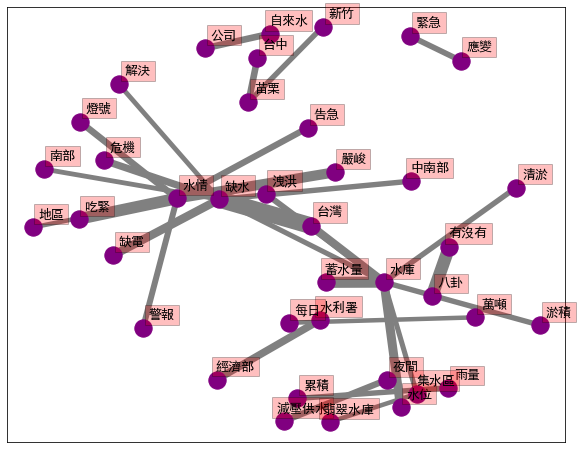

In [68]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

## 8. Pairwise correlation
計算兩個詞彙間的相關性 Phi相關係數(Phi coefficient)  
<img src="./img/pic1.png" style="float:left;" width="50%">  
<img src="./img/pic2.png" style="float:left;" width="25%">

In [69]:
#取常一起出現的bigram pair 前500筆
b = {k:v for k,v in bigramfdist.most_common(500)}
# b.items()

In [70]:
#建立DataFrame
bigram_df = pd.DataFrame(columns=['word', 'word2','n'])
for k,v in b.items():
    bigram_df = bigram_df.append({'word':k[0], 'word2':k[1], 'n':v}, ignore_index=True)

In [71]:
#計算phi值
def phi_cor(df):
    #total x
    nx = len(set(word_count2[word_count2["word"]==df["word"]]["artUrl"]))
    tnx = len(MetaData)-nx
    #total y
    ny = len(set(word_count2[word_count2["word"]==df["word2"]]["artUrl"]))
    tny = len(MetaData)-ny
    #有x 有y
    x_ls = list(word_count2[word_count2["word"]==df["word"]]["artUrl"]) #單獨有x
    y_ls = list(word_count2[word_count2["word"]==df["word2"]]["artUrl"]) #單獨有y
    nxy = len(set(x_ls)&set(y_ls)) #取交集
    #有x 沒有y
    nxo = nx-nxy
    #沒有x 沒有y
    uxy = set(x_ls)|set(y_ls) #取聯集
    noo = len(set(list(MetaData["artUrl"]))-uxy) #取差集:全-有x有y
    #沒有x 有y
    noy = ny-nxy
    #print(nx,ny,tny,tnx,nxy,noo,nxo,noy)
    phi = (nxy*noo-nxo*noy)/math.sqrt(nx*ny*tny*tnx)
    
    return phi

In [72]:
bigram_df["cor"] = bigram_df.apply(phi_cor, axis=1)
bigram_df = bigram_df[bigram_df["word"]!=bigram_df["word2"]]

In [73]:
bigram_df

,word,word2,n,cor
0,台灣,缺水,56,0.283542
1,有沒有,八卦,42,0.550136
2,水情,吃緊,39,0.506148
3,水庫,蓄水量,37,0.208623
4,水情,嚴峻,34,0.461333
...,...,...,...,...
495,因應,措施,4,0.373047
496,抗旱,措施,4,0.337908
497,備援,水井,4,0.326551
498,多個,水庫,4,0.137852


### 8.1 和 水庫, 缺水 相關性最高的 15 個詞彙

In [74]:
c_sum = bigram_df[(bigram_df["word"]=="水庫")].sort_values(by=['cor'], ascending = False).head(15)
b_sum = bigram_df[(bigram_df["word"]=="缺水")].sort_values(by=['cor'], ascending = False).head(15)

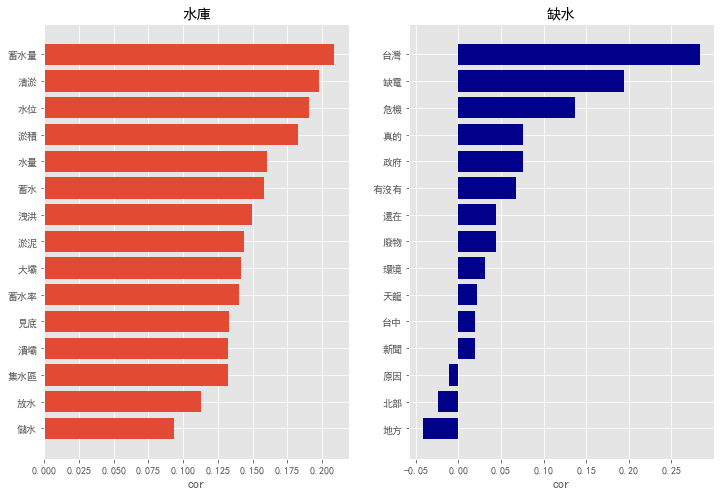

In [75]:
c_sum = c_sum.sort_values(by=['cor'])
b_sum = b_sum.sort_values(by=['cor'])

plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
# plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('水庫')
plt.xlabel('cor')
plt.barh(c_sum['word2'],c_sum['cor'])

plt.subplot(122)
plt.title('缺水')
plt.xlabel('cor')
plt.barh(b_sum['word2'],b_sum['cor'],color="darkblue")


plt.show()

### 8.2 使用詞彙關係圖畫出相關性大於0.4的組合

In [76]:
bigram_df[bigram_df["cor"]>0.4]

,word,word2,n,cor
1,有沒有,八卦,42,0.550136
2,水情,吃緊,39,0.506148
4,水情,嚴峻,34,0.461333
8,經濟部,水利署,25,0.581128
11,苗栗,台中,22,0.645506
...,...,...,...,...
469,呼籲,節約用水,4,0.425481
477,台積,電聯,4,0.497658
478,汙水,處理廠,4,0.497658
480,西南,氣流,4,0.705450


In [77]:
word_cors = bigram_df[bigram_df["cor"]>0.4]
word_cors.reset_index(inplace=True, drop=True)

In [78]:
import networkx as nx
# Create network plot 
g = nx.Graph()

# 建立 nodes 間的連結
for i in range(len(word_cors)):
    g.add_edge(word_cors["word"][i], word_cors["word2"][i], weight=word_cors["cor"][i])
    
# 取得edge權重
weights = [w[2]['weight']*10 for w in  g.edges(data=True)]

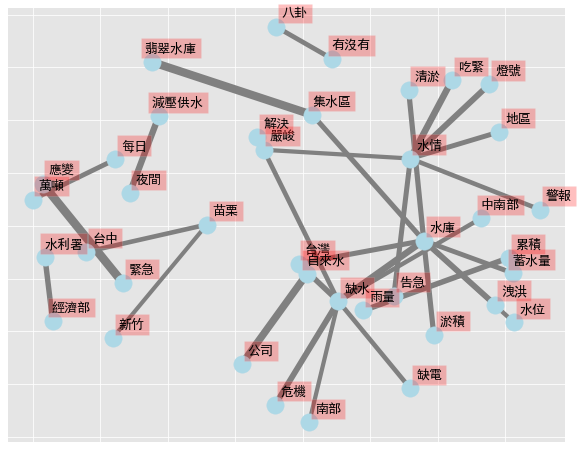

In [83]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='lightblue',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

## 9. 計算文章相似度
以TF-IDF的結果當作文章的向量，計算 Cosine Similarity 找出相似的文章  
<img src="./img/pic3.PNG" style="float:left;" width="50%">  

In [84]:
data_cos= MetaData.copy()
data_cos = data_cos.loc[:,["artTitle","artDate","artUrl","sentence"]]
# 需要改成使用空格連接斷好的詞
data_cos['word'] = data_cos.sentence.apply(getToken).map(' '.join)

In [85]:
# data_cos.head(2)

,artTitle,artDate,artUrl,sentence,word
0,[問卦]台灣水情吃緊跟鳳梨外銷中國誰比較重要！,2021/3/1,https://www.ptt.cc/bbs/Gossiping/M.1614606334....,魯蛇家鄉最近停水好幾天引起民怨就查了最近的水情資料發現最近新竹以南水情不是很樂觀卻沒有中央官...,魯蛇 家鄉 停水 幾天 民怨 就查 水情 資料 發現 新竹 以南 水情 樂觀 中央 官員 呼...
1,[新聞]水情告急！新竹以南7水庫蓄水率陷10%保,2021/3/2,https://www.ptt.cc/bbs/Gossiping/M.1614654780....,新頭殼顏得智水情告急新竹以南水庫蓄水率陷保衛戰春季雨量展望暫不樂觀水情告急嘉義台南地區於月日...,頭殼 顏得智 水情 告急 新竹 以南 水庫 蓄水率 保衛戰 春季 雨量 展望 樂觀 水情 告...


In [86]:
# Bag of Word
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data_cos["word"])
vocabulary = vectorizer.get_feature_names()
# 轉成dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df.head()

,一丁點,一七,一上午,一下子,一九六四年,一事,一二,一人,一人發,一代,...,齊開,齋戒,龍坪河,龍河,龍潭,龍鎮,龍頭,龜山,龜甲,龜裂
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [87]:
transformer = TfidfTransformer()  
print(transformer) 
#將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)  
# print(tfidf.toarray())

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())
TFIDF_df.head()

TfidfTransformer()


,一丁點,一七,一上午,一下子,一九六四年,一事,一二,一人,一人發,一代,...,齊開,齋戒,龍坪河,龍河,龍潭,龍鎮,龍頭,龜山,龜甲,龜裂
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [88]:
# 計算 cosine_similarity
def cosine_similarity(vector):
    cos_list = []
    for i in tfidf.toarray():
        score = np.dot(vector, i)  / (norm(vector) * norm(i))
        cos_list.append(score)
    df = pd.DataFrame(cos_list, columns=["cos_similarity"])
    return df

找和第一篇文章相似的其他文章

In [91]:
print(tfidf.toarray()[1])
cos_df = cosine_similarity(tfidf.toarray()[1])

[0. 0. 0. ... 0. 0. 0.]


In [92]:
cos_df = cos_df.merge(data_cos, how = 'left', left_index=True, right_index=True)
# cos_df.head()
cos_df.loc[:,["cos_similarity","artTitle"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

,cos_similarity,artTitle
1,1.000000,[新聞]水情告急！新竹以南7水庫蓄水率陷10%保
453,0.246861,[新聞]北南水庫兩樣情七月前北中「不會渴」南
624,0.242576,[新聞]翡翠水庫喝撐中南部卻喊渴
564,0.232970,[新聞]全台7水庫蓄水量不到5成
549,0.231409,[新聞]水情拉警報10/14起桃竹苗中一階夜間限水
416,0.219796,[新聞]全台水情拉警報石門水庫蓄水率跌破3成
381,0.208508,[新聞]竹苗台中水情慘石門水庫下週「北水南送
518,0.194331,[新聞]颱風不來水庫開始喊渴枯水季挫得等
403,0.179783,[新聞]水情吃緊曾文蓄水率僅1成47
600,0.178023,[新聞]水情不佳黃偉哲：做最壞打算
